In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from scipy.stats.mstats import winsorize
import scipy.stats as ss 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
import math
import seaborn as sns  

### 시장 평균 수익률, 위험 구하기
1. 데이터 수집 기간 : 2017.01.01 ~ 2022.05.18 (5년)

In [34]:
def Market(start,end,code,freq):
    import pandas as pd
    from pykrx import stock
    import math    
    
    mReturn = pd.DataFrame(stock.get_index_ohlcv(start,end,code,freq)['종가'])
    mReturn = mReturn.pct_change()
    mReturn.dropna(axis=0,inplace=True)

    returns = mReturn['종가']
    geomean=1.0
    n  =len(returns)/21
    for r in returns:
        geomean = geomean*(1+r)
    geomean = (geomean**(1/n)) -1
      
    sumsquare = sum((r-geomean)**2 for r in returns)
    var = sumsquare/(len(returns)-1)
    
    stdev = math.sqrt(var)
    stdev = stdev*math.sqrt(21)
    
    
    print(f'시장평균수익률:{geomean*100:.4f}(%,월)')
    print(var)
    print(f'시장위험:{stdev*100:.4f}(%,월)')
    
Market('20170101','20220518','1028','d')  #일별 데이터로 받아와서 월단위로 환산할 경우

시장평균수익률:0.4642(%,월)
0.0001510400634454227
시장위험:5.6319(%,월)


In [33]:
def Market(start,end,code,freq):
    import pandas as pd
    from pykrx import stock
    import math    
    
    mReturn = pd.DataFrame(stock.get_index_ohlcv(start,end,code,freq)['종가'])
    mReturn = mReturn.pct_change()
    mReturn.dropna(axis=0,inplace=True)

    returns = mReturn['종가']
    geomean=1.0
    n  =len(returns)  
    for r in returns:
        geomean = geomean*(1+r)
    geomean = (geomean**(1/n)) -1
      
    sumsquare = sum((r-geomean)**2 for r in returns)
    var = sumsquare/(len(returns)-1)
    
    stdev = math.sqrt(var)
    
    print(f'시장평균수익률:{geomean*100:.4f}(%,월)')
    print(var)
    print(f'시장위험:{stdev*100:.4f}(%,월)')
    
Market('20170101','20220518','1028','m')  #처음부터 월별 데이터로 구하기
    

시장평균수익률:0.4100(%,월)
0.0024859717700312575
시장위험:4.9860(%,월)


### 시장MDD 구하기

In [4]:
def mdd( x ):
    import numpy as np
    
    arr = np.array( x )
    idx_lower = np.argmin( arr - np.maximum.accumulate( arr ) )
    idx_upper = np.argmax( arr[ :idx_lower ] )
    return ( arr[ idx_lower ] - arr[ idx_upper ] ) / arr[ idx_upper ]

def get_index_mdd(start,end,code):
    from pykrx import stock
    
    data = stock.get_index_ohlcv(start,end,code)
    close = data['종가'].values
    print(mdd(close))
    
get_index_mdd('20170101','20220518','1001')

-0.4389786736150936


### 개별 종목 MDD 구하기

In [6]:
import pandas as pd
stock = pd.read_csv('./mydatasets/ksclose.csv',index_col=0)
stock = stock.dropna(axis=1)
ind_mdd = []
for tick in stock.columns:
    close = stock[tick]
    ind_mdd.append(mdd(close))
    

mdd_dt = pd.DataFrame(index=stock.columns,data=ind_mdd)
mdd_dt.rename(columns={0:'MDD'}, inplace=True)
mdd_dt

,MDD
005930,-0.287912
000660,-0.383838
207940,-0.572774
035420,-0.405286
006400,-0.411261
...,...
012280,-0.563452
012320,-0.775292
012600,-0.832937
013000,-0.844666


### 스타일 배분

#### 대형주 , 중소형주 구분

In [9]:
tickers_17 = pd.DataFrame(stock.get_market_ticker_list("20170101"),columns=['17'])
tickers_22 = pd.DataFrame(stock.get_market_ticker_list("20220101"),columns=['22'])
tic = pd.merge(tickers_17,tickers_22,left_on='17',right_on='22',how='inner')
tickers_final = tic['22']
tickers_final =pd.DataFrame({'code' :tickers_final})

cap = pd.DataFrame(stock.get_market_cap('20220518')['시가총액'])
cap = pd.merge(tickers_final,cap, left_on='code',right_index=True, how='inner')
    
cap= cap.sort_values(by='시가총액',ascending=False)
cap = cap.reset_index(drop=True)
big = cap.iloc[:100,:]
m_s = cap.iloc[100:,:]

big_code = big['code']
big_code.to_csv('./mydatasets/bigcode.csv')

ms_code = m_s['code']
ms_code.to_csv('./mydatasets/ms_code.csv')

#### 성장주,가치주 구분
**가치점수**   
1. E/P  
2. B/P

**성장점수**  
1. 12-month Momentum  
2. $ \frac {P}{3-year \; EPS \; Net Change} $

In [10]:
fm = stock.get_market_fundamental('2022-05-18')
fm['E/P'] = (1/fm['PER']) # 역수 취하기
fm['B/P'] = (1/fm['PBR'])
fm = fm.query('PER != 0').sort_values('PER') # 결측값 제거

# E/P 구하기
ep = pd.DataFrame({'E/P':fm['E/P'].sort_values(ascending=False)})
ep['winE/P'] = winsorize(ep['E/P'],limits=[0.05,0.05])  # 이상치 조절
ep['stE/P'] = ss.zscore(ep['winE/P']) # z-score

# B/P 구하기
bp  = pd.DataFrame({'B/P':fm['B/P'].sort_values(ascending=False)})
bp['winB/P'] = winsorize(bp['B/P'],limits=[0.05,0.05])
bp['stB/P'] = ss.zscore(bp['winB/P'])

# 가치점수(VS) 만들기
value_S = pd.merge(ep,bp,left_index=True,right_index=True,how='inner')
value_S['VS'] = (value_S.iloc[:,2]+value_S.iloc[:,5])/2
value_S.sort_values(by='VS',ascending=False)

,E/P,winE/P,stE/P,B/P,winB/P,stB/P,VS
티커,,,,,,,
375500,0.537634,0.369004,2.462157,3.846154,3.225806,2.107546,2.284852
003240,0.381679,0.369004,2.462157,4.761905,3.225806,2.107546,2.284852
002030,0.418410,0.369004,2.462157,3.571429,3.225806,2.107546,2.284852
088350,0.578035,0.369004,2.462157,5.882353,3.225806,2.107546,2.284852
017940,0.454545,0.369004,2.462157,4.545455,3.225806,2.107546,2.284852
...,...,...,...,...,...,...,...
271940,0.006667,0.011637,-1.133560,0.198413,0.250627,-1.325153,-1.229356
009420,0.010875,0.011637,-1.133560,0.199601,0.250627,-1.325153,-1.229356
373220,0.009666,0.011637,-1.133560,0.097182,0.250627,-1.325153,-1.229356


In [11]:
# 상장된 기업의 종가만 사용
close22 = pd.DataFrame({'22':stock.get_market_ohlcv('20220518')['종가']})
close21 = pd.DataFrame({'21':stock.get_market_ohlcv('20210518')['종가']})
ks = pd.merge(close21,close22,left_index=True,right_index=True,how='inner')

# 12개월 모멘텀 
ks['Momentum'] =((ks['22']-ks['21'])/ks['21'])*100
ks.rename(columns={'21':'매수가','22':'매도가'},inplace=True)
ks['win_MM'] = winsorize(ks['Momentum'],limits=[0.05,0.05])
ks['stn_MM'] = ss.zscore(ks['win_MM'])


# 3년 EPS 증가율 구하기
df_20 = pd.DataFrame(stock.get_market_fundamental('2020-05-01')['EPS'])
df_20.rename(columns={'EPS':'EPS_20'},inplace=True)
df_22 = pd.DataFrame(stock.get_market_fundamental('2022-05-01')['EPS'])
df_22.rename(columns={'EPS':'EPS_22'},inplace=True)
eps = pd.merge(df_20,df_22,left_index=True,right_index=True,how='inner')
eps['NetChange'] = eps['EPS_22']-eps['EPS_20']

# 3년 EPS 증가율 대비 주가 (대략 PEG 개념)
eps = pd.merge(eps,close22,left_index=True,right_index=True,how='inner')
eps['approxPEG'] = (eps['NetChange']/eps['22'])
eps['win_P'] = winsorize(eps['approxPEG'],limits=[0.05,0.05])
eps.loc[eps['NetChange']==0,'win_P'] = 0 # 정규화하기 전에 필요
eps['stn_P'] = ss.zscore(eps['win_P'])

# 성장점수(GS) 만들기
growth_S = pd.merge(ks['stn_MM'],eps['stn_P'],left_index=True,right_index=True,how='inner')
growth_S['GS'] = (growth_S.iloc[:,0] + growth_S.iloc[:,1])/2
growth_S.sort_values('GS',ascending=False)

,stn_MM,stn_P,GS
티커,,,
003030,2.597269,2.585338,2.591303
005010,2.298508,2.207666,2.253087
002220,2.278359,2.201590,2.239974
006200,1.874995,2.585338,2.230166
009160,2.597269,1.819816,2.208542
...,...,...,...
031430,-1.507091,-1.675289,-1.591190
183190,-1.507091,-1.675289,-1.591190
300720,-1.507091,-1.675289,-1.591190


In [12]:
# 데이터 합치기
style = pd.merge(value_S['VS'],growth_S['GS'],left_index=True,right_index=True,how='inner')
style= style.sort_values('GS',ascending=False)

In [13]:
# 성장 점수 순위 컬럼 생성
style['GS_Rank'] = style['GS'].rank(method='min',ascending=False)

# 가치 점수 순위 컬럼 생성
style['VS_Rank'] = style['VS'].rank(method='min',ascending=False)
# style.sort_values(by='VS_Rank')

# 스타일 순위 매기기 
style['Rank'] = style.iloc[:,2]/style.iloc[:,3]
# style.sort_values(by='Rank')

In [14]:
# 시가총액 불러오기
cap = pd.DataFrame(stock.get_market_cap('20220518')['시가총액'])
style_dt= pd.merge(style,cap,left_index=True,right_index=True,how='inner')
total_cap = style_dt.시가총액.sum()

# 전체 시총 대비 개별 종목 시총 비율 구하기
style_dt['cap_ratio'] = style_dt.iloc[:,5]/total_cap

# 개별 종목 시총 누적비율 컬럼 생성
style_dt=style_dt.sort_values(by='Rank')
style_dt['cum_cap'] = style_dt['cap_ratio'].cumsum()

# 시총 비율로 3구간 나눠서 성장,중간,가치 그룹화 하기
GS = style_dt[style_dt['cum_cap'] <= 0.33]
GS['group'] = 'growth'

NEUTRAL = style_dt[(style_dt['cum_cap'] > 0.33) & (style_dt['cum_cap'] <= 0.67)]
NEUTRAL['group'] = 'neutral'

VS = style_dt[style_dt['cum_cap']>0.67]
VS['group'] = 'value'

style_group = pd.concat([GS,NEUTRAL,VS],axis=0)
style_group

GS.to_csv('./mydatasets/pGrowth_1.csv')
VS.to_csv('./mydatasets/pValue_1.csv')


In [15]:
# 나눈 구간으로 실제 시총 비율 확인하기 
growth_cap = style_group.groupby('group').get_group('growth').sum().시가총액
neutral_cap = style_group.groupby('group').get_group('neutral').sum().시가총액
value_cap = style_group.groupby('group').get_group('value').sum().시가총액

print((growth_cap/total_cap)*100)
print((neutral_cap/total_cap)*100)
print((value_cap/total_cap)*100)

# 스타일별 종목 개수 확인
print('\n',style_group.group.value_counts())

31.214495847013552
35.688784008725065
33.09672014426138

 value      329
growth     198
neutral     74
Name: group, dtype: int64


#### 분포로 확인하기

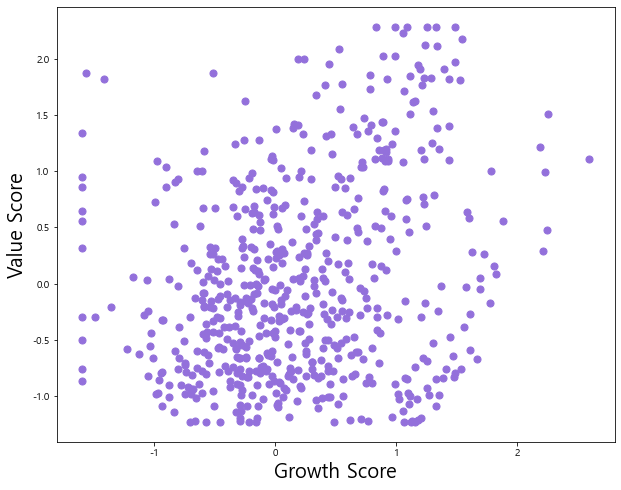

In [16]:
# 산점도로 점수별 종목 분포 확인
plt.figure(figsize=(10,8))
plt.scatter(style['GS'],style['VS'],s=50, c='mediumpurple')  #,c='mediumpurple'
plt.xlabel('Growth Score',size=20)
plt.ylabel('Value Score',size=20)
plt.show()

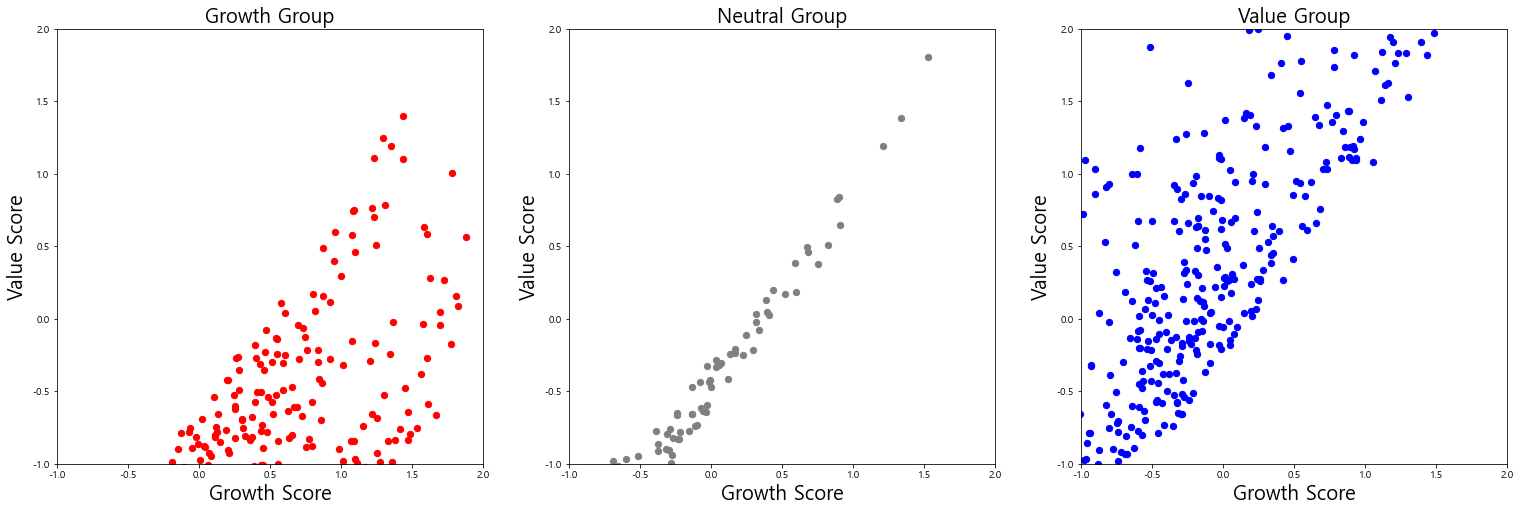

In [17]:
# 성장, 중립, 가치 그룹별 분포 확인

plt.figure(figsize=(26,8))

plt.subplot(1,3,1)
plt.scatter(GS['GS'],GS['VS'],s=40,c='red')
plt.title('Growth Group',size=20)
plt.xlabel('Growth Score',size=20)
plt.ylabel('Value Score',size=20)
plt.xlim([-1.0,2.0])
plt.ylim([-1.0,2.0])

plt.subplot(1,3,2)
plt.scatter(NEUTRAL['GS'],NEUTRAL['VS'],s=40,c='gray')
plt.title('Neutral Group',size=20)
plt.xlabel('Growth Score',size=20)
plt.ylabel('Value Score',size=20)
plt.xlim([-1.0,2.0])
plt.ylim([-1.0,2.0])

plt.subplot(1,3,3)
plt.scatter(VS['GS'],VS['VS'],s=40,c='blue')
plt.title('Value Group',size=20)
plt.xlabel('Growth Score',size=20)
plt.ylabel('Value Score',size=20)
plt.xlim([-1.0,2.0])
plt.ylim([-1.0,2.0])
plt.show()

#### (건너뛰기)NEUTRAL 종목들 성장, 가치로 분류하는 단계(프로젝트에서는 사용하지 않음)

###### AV,AG 계산

In [28]:
n = NEUTRAL

print(f'AV_G :{VS.GS.mean()}')
print(f'AV_V :{VS.VS.mean()}')
print(f'AG_G :{GS.GS.mean()}')
print(f'AG_V :{GS.VS.mean()}')

AV_G :-0.11471125360294596
AV_V :0.4166003384710115
AG_G :0.7661368048973679
AG_V :-0.46494926469666087


##### Neutral Group Midpoint Distance

######  $D_{G,X}$

<img width="392" alt="화면 캡처 2022-05-23 155207" src="https://user-images.githubusercontent.com/99321739/169760679-81400879-f681-4a14-bf5f-e3af42cadbd2.png">


In [29]:
# if 에 해당
g_first = n[n['GS']>=GS.GS.mean()]
g_first['D(G,X)'] = abs(g_first.iloc[:,0]-GS.VS.mean())
# g_first

# Else if 에 해당
g_second = n[n['VS']<=-GS.VS.mean()]
g_second['D(G,X)'] =abs(GS.GS.mean() - g_second.iloc[:,1])
# g_second

#Else에 해당
g_third = n.drop(index=(g_first.index.tolist() + g_second.index.tolist()))
g_third['D(G,X)'] = (((g_third.iloc[:,0])-GS.VS.mean())**2 + (GS.GS.mean()-g_third.iloc[:,1])**2)**(1/2)
# g_third

# If/Else if/ Else 결과 합치기 
ng_total = pd.concat([g_first,g_second,g_third],axis=0)
ng_total

,VS,GS,GS_Rank,VS_Rank,Rank,시가총액,cap_ratio,cum_cap,group,"D(G,X)"
티커,,,,,,,,,,
000880,1.382653,1.334020,42.0,53.0,0.792453,2113836327000,0.001259,0.341385,neutral,1.847602
018670,0.647957,0.905513,115.0,145.0,0.793103,1227622452000,0.000731,0.342116,neutral,1.112906
095570,0.512001,0.822504,135.0,169.0,0.798817,319328051900,0.000190,0.342432,neutral,0.976950
029530,1.808499,1.527128,25.0,30.0,0.833333,334152961350,0.000199,0.344383,neutral,2.273448
000370,1.190280,1.208077,65.0,71.0,0.915493,518320782600,0.000309,0.606185,neutral,1.655230
...,...,...,...,...,...,...,...,...,...,...
004370,-0.325223,-0.028844,353.0,360.0,0.980556,1666643908000,0.000992,0.657255,neutral,0.794981
003080,-0.468075,-0.133365,381.0,387.0,0.984496,90390300000,0.000054,0.657309,neutral,0.899502
007570,-0.978444,-0.691054,542.0,545.0,0.994495,458055936000,0.000273,0.657581,neutral,1.457191


###### $D_{V,X}$

<img width="374" alt="화면 캡처 2022-05-23 155223" src="https://user-images.githubusercontent.com/99321739/169760765-dabd8ded-92be-48d2-b8e1-c6932052682d.png">

In [30]:
# IF 에 해당
v_first = n[n['VS'] >= VS.VS.mean()]
v_first['D(V,X)'] = abs(v_first.iloc[:,1]-(VS.GS.mean()))
# v_first

# Else if 에 해당
v_second = n[n['GS'] <= VS.GS.mean()]
v_second['D(V,X)'] = abs(VS.VS.mean() - v_second.iloc[:,0])
# v_second

# Else 에 해당
v_thrid = n.drop(index=(v_first.index.tolist() + v_second.index.tolist()))
v_thrid['D(V,X)'] = ((v_thrid.VS-VS.VS.mean())**2 + (VS.GS.mean()-v_thrid.GS)**2)**(1/2)
# v_thrid

# IF/Else if/Else 합치기
nv_total = pd.concat([v_first,v_second,v_thrid],axis=0)
nv_total

,VS,GS,GS_Rank,VS_Rank,Rank,시가총액,cap_ratio,cum_cap,group,"D(V,X)"
티커,,,,,,,,,,
000880,1.382653,1.334020,42.0,53.0,0.792453,2113836327000,0.001259,0.341385,neutral,1.448731
018670,0.647957,0.905513,115.0,145.0,0.793103,1227622452000,0.000731,0.342116,neutral,1.020225
095570,0.512001,0.822504,135.0,169.0,0.798817,319328051900,0.000190,0.342432,neutral,0.937215
029530,1.808499,1.527128,25.0,30.0,0.833333,334152961350,0.000199,0.344383,neutral,1.641839
075180,0.458438,0.681412,161.0,179.0,0.899441,110784000000,0.000066,0.595766,neutral,0.796124
...,...,...,...,...,...,...,...,...,...,...
002600,0.033367,0.318641,245.0,257.0,0.953307,112800000000,0.000067,0.611505,neutral,0.578499
039570,-0.438181,-0.076070,365.0,382.0,0.955497,245299329450,0.000146,0.611651,neutral,0.855654
210980,0.127683,0.389365,228.0,236.0,0.966102,640186231400,0.000381,0.624709,neutral,0.581004


###### Weight 구하기

<img width="222" alt="화면 캡처 2022-05-23 173547" src="https://user-images.githubusercontent.com/99321739/169778806-7fb20fa7-f7f6-4900-8479-3d1c63b48464.png">

In [31]:
# ng,nv 데이터 합치기 
nw = pd.merge(ng_total['D(G,X)'],nv_total['D(V,X)'], left_index=True,right_index=True, how='inner')
# nw

# weight 구하기
nw['W(V,X)'] = nw['D(G,X)']/(nw['D(G,X)']+nw['D(V,X)'])
nw['W(G,X)'] = nw['D(V,X)']/(nw['D(G,X)']+nw['D(V,X)'])
nw

,"D(G,X)","D(V,X)","W(V,X)","W(G,X)"
티커,,,,
000880,1.847602,1.448731,0.560502,0.439498
018670,1.112906,1.020225,0.521724,0.478276
095570,0.976950,0.937215,0.510379,0.489621
029530,2.273448,1.641839,0.580659,0.419341
000370,1.655230,1.322788,0.555816,0.444184
...,...,...,...,...
004370,0.794981,0.746776,0.515633,0.484367
003080,0.899502,0.884675,0.504155,0.495845
007570,1.457191,1.395044,0.510894,0.489106


##### group 정하기


In [32]:
# W값이 더 큰쪽으로 성장,가치 분류
style_n = nw
group = []
for code in range(len(style_n.index)):
    if style_n.iloc[code,2] > style_n.iloc[code,3]:
        group.append('value')
    else:
        group.append('growth')
style_n['group'] = group
style_n

,"D(G,X)","D(V,X)","W(V,X)","W(G,X)",group
티커,,,,,
000880,1.847602,1.448731,0.560502,0.439498,value
018670,1.112906,1.020225,0.521724,0.478276,value
095570,0.976950,0.937215,0.510379,0.489621,value
029530,2.273448,1.641839,0.580659,0.419341,value
000370,1.655230,1.322788,0.555816,0.444184,value
...,...,...,...,...,...
004370,0.794981,0.746776,0.515633,0.484367,value
003080,0.899502,0.884675,0.504155,0.495845,value
007570,1.457191,1.395044,0.510894,0.489106,value


### 최종 스타일배분 결과 

In [18]:
mdd = pd.read_csv('./mydatasets/mdd.csv',index_col=0)
def zcode(df):
    Code = []
    for code in (df.index):
        code = str(code)    
        Code.append(code.zfill(6)) 
    df.index = Code
zcode(mdd)

In [19]:
# MDD 기준 45%로 종목 선정하기 

VS_1 = VS[['Rank']]
GS_1 = GS[['Rank']]

b_g = pd.merge(big_code,GS_1, left_on='code',right_index=True, how='inner')
b_v = pd.merge(big_code,VS_1, left_on='code',right_index=True, how='inner')

ms_g = pd.merge(ms_code,GS_1, left_on='code',right_index=True, how='inner')
ms_v = pd.merge(ms_code,VS_1, left_on='code',right_index=True, how='inner')

b_g_mdd = pd.merge(b_g,mdd,left_on='code', right_index=True, how='inner')
b_g_select = b_g_mdd[b_g_mdd.MDD >= -0.45]
# b_g_select

b_v_mdd = pd.merge(b_v,mdd,left_on='code', right_index=True, how='inner')
b_v_select = b_v_mdd[b_v_mdd.MDD >= -0.45]
# b_v_select

ms_g_mdd = pd.merge(ms_g,mdd,left_on='code', right_index=True, how='inner')
ms_g_select = ms_g_mdd[ms_g_mdd.MDD >= -0.45]
# ms_g_select

ms_v_mdd = pd.merge(ms_v,mdd,left_on='code', right_index=True, how='inner')
ms_v_select = ms_v_mdd[ms_v_mdd.MDD >= -0.45]
# ms_v_select


In [20]:
b_g_name=[]
for code in b_g_select['code']:
    n = stock.get_market_ticker_name(code)
    b_g_name.append(n)
# b_g_name

b_v_name=[]
for code in b_v_select['code']:
    n = stock.get_market_ticker_name(code)
    b_v_name.append(n)
# b_v_name

ms_g_name=[]
for code in ms_g_select['code']:
    n = stock.get_market_ticker_name(code)
    ms_g_name.append(n)
# ms_g_name

ms_v_name=[]
for code in ms_v_select['code']:
    n = stock.get_market_ticker_name(code)
    ms_v_name.append(n)
# ms_v_name

In [21]:
b_g_df = pd.DataFrame({'대형성장주코드':b_g_select['code'],'대형성장주이름':b_g_name})
b_g_df.reset_index(drop=True, inplace=True)

b_v_df = pd.DataFrame({'대형가치주코드':b_v_select['code'],'대형가치주이름':b_v_name})
b_v_df.reset_index(drop=True, inplace=True)

ms_g_df = pd.DataFrame({'중소형성장주코드':ms_g_select['code'],'중소형성장주이름':ms_g_name})
ms_g_df.reset_index(drop=True, inplace=True)

ms_v_df = pd.DataFrame({'중소형가치주코드':ms_v_select['code'],'중소형가치주이름':ms_v_name})
ms_v_df.reset_index(drop=True, inplace=True)

pd.concat([b_g_df,b_v_df,ms_g_df,ms_v_df],axis=1).fillna("")

,대형성장주코드,대형성장주이름,대형가치주코드,대형가치주이름,중소형성장주코드,중소형성장주이름,중소형가치주코드,중소형가치주이름
0,000660,SK하이닉스,005380,현대차,093370,후성,042700,한미반도체
1,035420,NAVER,017670,SK텔레콤,195870,해성디에스,181710,NHN
2,006400,삼성SDI,003550,LG,016710,대성홀딩스,214320,이노션
3,000270,기아,029780,삼성카드,017390,서울가스,003530,한화투자증권
4,011790,SKC,000120,CJ대한통운,034120,SBS,001530,DI동일
5,000100,유한양행,,,002840,미원상사,034310,NICE
6,138040,메리츠금융지주,,,017960,한국카본,001880,DL건설
7,020150,일진머티리얼즈,,,001720,신영증권,003070,코오롱글로벌
8,000990,DB하이텍,,,009160,SIMPAC,007690,국도화학
9,052690,한전기술,,,092220,KEC,008490,서흥


In [22]:
new =pd.concat([b_g_df,b_v_df,ms_g_df,ms_v_df],axis=1)
# new.to_csv('./new_style.csv')

### index로 만들어서 수익률 간 상관성 확인하기

In [23]:
def style_index(style,start,end,freq):  #freq = 'd','m','y'
    df_total = pd.DataFrame()
    for code in style:        
        df = stock.get_market_cap(start, end, code,freq)['시가총액']
        df_total = pd.concat([df_total, df],axis=1)
        df_total.rename(columns={'시가총액':f'{code}시가총액'},inplace=True)
        time.sleep(1)
    df_total['Sum'] = df_total.sum(axis=1)
    df_total['index'] = (df_total['Sum']/df_total['Sum'].iloc[0]) *100
    
    return df_total

In [ ]:
# 약 7~8분 소요 # 
b_g_index = style_index(new['대형성장주코드'].dropna(),'20161201','20220518','m')[['index']]
b_g_index['return'] = b_g_index.pct_change()
b_g_index = b_g_index.fillna(0)

b_v_index = style_index(new['대형가치주코드'].dropna(),'20161201','20220518','m')[['index']]
b_v_index['return'] = b_v_index.pct_change()
b_v_index = b_v_index.fillna(0)

ms_g_index = style_index(new['중소형성장주코드'].dropna(),'20161201','20220518','m')[['index']]
ms_g_index['return'] = ms_g_index.pct_change()
ms_g_index = ms_g_index.fillna(0)

ms_v_index = style_index(new['중소형가치주코드'].dropna(),'20161201','20220518','m')[['index']]
ms_v_index['return'] = ms_v_index.pct_change()
ms_v_index = ms_v_index.fillna(0)

# b_g_index.to_csv('./mydatasets/b_g_index.csv')
# b_v_index.to_csv('./mydatasets/b_v_index.csv')
# ms_g_index.to_csv('./mydatasets/ms_g_index.csv')
# ms_v_index.to_csv('./mydatasets/ms_v_index.csv')

In [ ]:
# new 파일 불러와서 할 경우(위에 셀 대신 실행)
"""
new = pd.read_csv('./new_style.csv',index_col=0)
new.fillna(0,inplace=True)
def new_zfill(style):
    Code = []
    for code in (new[f'{style}주코드']):
        code = float(code)
        code = math.ceil(code)
        code = str(code)    
        Code.append(code.zfill(6)) 

    new[f'{style}주코드'] = Code
    
new_zfill('대형성장')
new_zfill('대형가치')
new_zfill('중소형성장')
new_zfill('중소형가치')

b_g = new.iloc[:11,:2]
b_v = new.iloc[:5,2:4]
ms_g = new.iloc[:,4:6]
ms_v = new.iloc[:24,6:]

b_g_index = style_index(b_g['대형성장주코드'].dropna(),'20161201','20220518','m')[['index']]
b_g_index['return'] = b_g_index.pct_change()
b_g_index = b_g_index.fillna(0)

b_v_index = style_index(b_v['대형가치주코드'].dropna(),'20161201','20220518','m')[['index']]
b_v_index['return'] = b_v_index.pct_change()
b_v_index = b_v_index.fillna(0)

ms_g_index = style_index(ms_g['중소형성장주코드'].dropna(),'20161201','20220518','m')[['index']]
ms_g_index['return'] = ms_g_index.pct_change()
ms_g_index = ms_g_index.fillna(0)

ms_v_index = style_index(ms_v['중소형가치주코드'].dropna(),'20161201','20220518','m')[['index']]
ms_v_index['return'] = ms_v_index.pct_change()
ms_v_index = ms_v_index.fillna(0)

# b_g_index.to_csv('./mydatasets/b_g_index.csv')
# b_v_index.to_csv('./mydatasets/b_v_index.csv')
# ms_g_index.to_csv('./mydatasets/ms_g_index.csv')
# ms_v_index.to_csv('./mydatasets/ms_v_index.csv')
"""


In [24]:

# index 파일 불러와서 다시 시작하면 됨
b_g_index = pd.read_csv('./mydatasets/b_g_index.csv',index_col=0)
b_v_index = pd.read_csv('./mydatasets/b_v_index.csv',index_col=0)
ms_g_index = pd.read_csv('./mydatasets/ms_g_index.csv',index_col=0)
ms_v_index = pd.read_csv('./mydatasets/ms_v_index.csv',index_col=0)

b_g_index.drop(index=['2016-12-31 00:00:00','2022-05-31 00:00:00'],inplace=True)
b_g_index.rename(columns={'return':'b_g_return','index':'b_g'},inplace=True)

b_v_index.drop(index=['2016-12-31 00:00:00','2022-05-31 00:00:00'],inplace=True)
b_v_index.rename(columns={'return':'b_v_return','index':'b_v'},inplace=True)

ms_g_index.drop(index=['2016-12-31 00:00:00','2022-05-31 00:00:00'],inplace=True)
ms_g_index.rename(columns={'return':'ms_g_return','index':'ms_g'},inplace=True)

ms_v_index.drop(index=['2016-12-31 00:00:00','2022-05-31 00:00:00'],inplace=True)
ms_v_index.rename(columns={'return':'ms_v_return','index':'ms_v'},inplace=True)

total_1 = pd.concat([b_g_index['b_g'],b_v_index['b_v'],ms_g_index['ms_g'],ms_v_index['ms_v']],axis=1)
total_return_1 = pd.concat([b_g_index['b_g_return'],b_v_index['b_v_return'],ms_g_index['ms_g_return'],ms_v_index['ms_v_return']],axis=1)

total_return_1.rename(columns={'b_g_return':'대형성장',
                               'b_v_return':'대형가치',
                               'ms_g_return':'중소형성장',
                               'ms_v_return':'중소형가치'},
                                inplace=True)

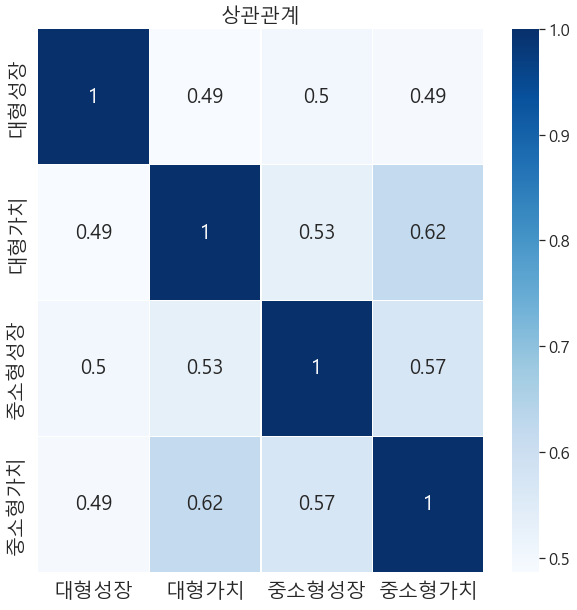

In [37]:
corr_1 = total_return_1.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.5,
        font = "Malgun Gothic",
        rc = {'axes.unicode_minus':False})
sns.heatmap(corr_1,
            ax=ax,
            annot=True,
            cmap="Blues",
            annot_kws={'size':20},
            linewidth=0.5)
ax.tick_params(labelsize=20)
ax.set_title('상관관계', fontsize=20)
plt.show()

#### 무위험자산 추가해서 상관성 분석

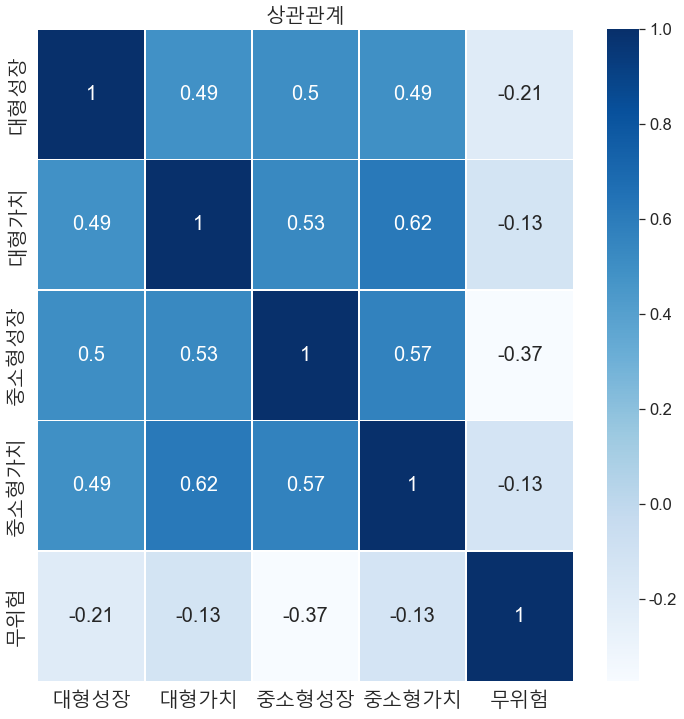

In [27]:
tbill = pd.read_csv('./mydatasets/rf_m.csv',index_col=0)
rf = tbill[['Rate_m']]
rf.reset_index(drop=True,inplace=True)
total_return_2 = total_return_1.reset_index(drop=True)
total_return_3 = pd.concat([total_return_2,rf],axis=1)

total_return_3.rename(columns={'b_g_return':'대형성장',
                               'b_v_return':'대형가치',
                               'ms_g_return':'중소형성장',
                               'ms_v_return':'중소형가치',
                               'Rate_m':'무위험'},inplace=True)
corr_3 = total_return_3.corr()

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.5,
        # font = "Malgun Gothic",
        rc = {'axes.unicode_minus':False})
sns.heatmap(corr_3,
            ax=ax,
            annot=True,
            cmap="Blues",
            annot_kws={'size':20},
            linewidth=0.5)
ax.tick_params(labelsize=20)
ax.set_title('상관관계', fontsize=20)
plt.show()